<a href="https://colab.research.google.com/github/tuba89/MachineLearning/blob/main/DecisionTree_RANDOMforest_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = '/content/drive/MyDrive/titanic-passengers for trees.csv'
data = pd.read_csv(path, sep=";")

# **Preprocess & clean our data**

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
3,568,No,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
4,672,No,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [ ]:
# replacing categorical values of survived by numbers
data['Survived'] = data['Survived'].replace({'No' : 0, 'Yes' : 1})

In [ ]:
# Feature that tells whether a passenger had a cabin on the Titanic
data['Cabin_n'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [ ]:
# Create new feature FamilySize as a combination of SibSp//Parch
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [ ]:
# Create new feature IsAlone from FamilySize
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

In [ ]:
# extract the title from the column Names
data['Title'] = data['Name'].apply(lambda full_name: full_name.split(', ')[1].split('.')[0])

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_n,FamilySize,IsAlone,Title
0,343,0,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S,0,1,1,Mr
1,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,1,1,1,Mr
2,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S,0,1,1,Mr
3,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S,0,5,0,Mrs
4,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S,1,2,0,Mr


In [ ]:
# replace the title
data['Title'] = data['Title'].replace(['Mr', 'Rev', 'Capt', 'Don','Jonkheer'], 'Brave')
data['Title'] = data['Title'].replace(['Col','Major','Master','Dr'], 'Second Brave')
data['Title'] = data['Title'].replace(['Sir','the Countess'], 'Royalty')
data['Title'] = data['Title'].replace(['Ms', 'Mlle', 'Miss', 'Mme', 'Mrs','Lady'], 'Women/Ladies')

In [ ]:
data['Title'].value_counts()

Brave           526
Women/Ladies    312
Second Brave     51
Royalty           2
Name: Title, dtype: int64

In [ ]:
# Remove all "NULLS" in "Embarked" feature
data['Embarked'] = data['Embarked'].fillna('S')

In [ ]:
# Remove all "NULLS" in "Fare" featre
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [ ]:
# put each person into one of four age groups: 
#Infant under <2, Child =2-12 , Adult =13-50, or Old >=50.
bins = [0, 1, 13, 50, 85]
age_groups = ['Baby','Child','Adult','Old']
data['Age'] = pd.cut(data['Age'], bins, labels = age_groups)

In [ ]:
def find_age_group(value):
    
    """ For unknown ages (NULLS value), find the best 'Age' group by looking at the form each name.
    For 'Miss' and 'Master', = 'Child' age group, and for 'Mrs', 'Mr.', and 'Dr.', 
    ==> 'Adult' age group """
        
    if 'Miss.' in value['Name']:
        if pd.isnull(value['Age']):
            value['Age'] = 'Child'
        
    if 'Master.' in value['Name']:
        if pd.isnull(value['Age']):
           value['Age'] = 'Child'
            
    if 'Mrs.' in value['Name']:
        if pd.isnull(value['Age']):
            value['Age'] = 'Adult'
            
    if 'Mr.' in value['Name']:
        if pd.isnull(value['Age']):
            value['Age'] = 'Adult'
        
    if 'Dr.' in value['Name']:
        if pd.isnull(value['Age']):
            value['Age'] = 'Adult' 
        
    return value
data = data.apply(find_age_group, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    int64 
 5   Age          891 non-null    object
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int64 
 10  Cabin        204 non-null    object
 11  Embarked     891 non-null    int64 
 12  Cabin_n      891 non-null    int64 
 13  FamilySize   891 non-null    int64 
 14  IsAlone      891 non-null    int64 
 15  Title        891 non-null    int64 
dtypes: int64(12), object(4)
memory usage: 111.5+ KB


In [ ]:
# mapping the Age
#age_groups = ['Baby','Child','Adult','Old']
data['Age'] = data['Age'].map( {'Baby': 0, 'Child': 1, 'Adult': 2, 'Old': 3} )

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    int64 
 5   Age          891 non-null    int64 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int64 
 10  Cabin        204 non-null    object
 11  Embarked     891 non-null    int64 
 12  Cabin_n      891 non-null    int64 
 13  FamilySize   891 non-null    int64 
 14  IsAlone      891 non-null    int64 
 15  Title        891 non-null    int64 
dtypes: int64(13), object(3)
memory usage: 111.5+ KB


In [ ]:
# Mapping the gender
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [ ]:
# # Mapping titles
# Brave           526
# Women/Ladies    312
# Second Brave     51
# Royalty           2
title_mapping = {"Brave": 1, "Second Brave": 2, "Women/Ladies": 3, "Royalty": 3}
# i put royality also 3 because there is just two of theme not much data to analysis
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)

In [ ]:
# Mapping Embarked
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [ ]:
# Mapping Fare
data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0 # almost free
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1 # cheap
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']  = 2 # medium
data.loc[ data['Fare'] > 31, 'Fare'] = 3 # EXPENSIVE
data['Fare'] = data['Fare'].astype(int)


In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_n,FamilySize,IsAlone,Title
0,343,0,2,"Collander, Mr. Erik Gustaf",1,2,0,0,248740,1,NaN,0,0,1,1,0
1,76,0,3,"Moen, Mr. Sigurd Hansen",1,2,0,0,348123,0,F G73,0,1,1,1,0
2,641,0,3,"Jensen, Mr. Hans Peder",1,2,0,0,350050,0,NaN,0,0,1,1,0
3,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",0,2,0,4,349909,2,NaN,0,0,5,0,2
4,672,0,1,"Davidson, Mr. Thornton",1,2,1,0,F.C. 12750,3,B71,0,1,2,0,0


In [ ]:
data['Age'].value_counts()

2    716
1     97
3     64
0     14
Name: Age, dtype: int64

# **Dropping the useless features**

In [ ]:
new_data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis = 1)

In [ ]:
new_data.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Cabin_n,FamilySize,IsAlone,Title
0,0,2,1,2,0,1,0,0,1,1,0
1,0,3,1,2,0,0,0,1,1,1,0
2,0,3,1,2,0,0,0,0,1,1,0
3,0,3,0,2,4,2,0,0,5,0,2
4,0,1,1,2,0,3,0,1,2,0,0


In [ ]:
new_data['IsAlone'].value_counts()

1    537
0    354
Name: IsAlone, dtype: int64

# Note: 
* now our data is clean
* and all the important categorical features are numerical



# **Modeling**

* **Training set and Testing set**

In [ ]:
#importing relevant libraries
from sklearn.model_selection import train_test_split
from sklearn import tree   
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 

In [ ]:
# features extraction
x = new_data.drop('Survived', axis=1)
y = new_data['Survived']

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.20, 
                                                    random_state = 10)

# Decision Tree

* **Apply decision tree**

In [ ]:
# applying tree algorithm
tree_clf = tree.DecisionTreeClassifier(max_depth=5) 

In [ ]:
# fitting our model
tree_model = tree_clf.fit(x_train, y_train) 

# evaluating our model
y_pred= tree_model.predict(x_test)


In [ ]:
confusion_matrix(y_test, y_pred)

array([[101,   4],
       [ 27,  47]])

- We want to minimize false positives and false negatives here:

    * ==> FP = 4 & FN = 27
    * it's pretty good in false positibe & it's not too bad in FN

In [ ]:
# Measuring the accuracy of our model
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

print("Accuracy score = %.2f" %accuracy,"%")
print("f1 score = %.2f" %f1,"%")
print("precision score = %.2f" %precision,"%")
print("recall score = %.2f" %recall,"%")

Accuracy score = 82.68 %
f1 score = 75.20 %
precision score = 92.16 %
recall score = 63.51 %


* **plotting the Tree**

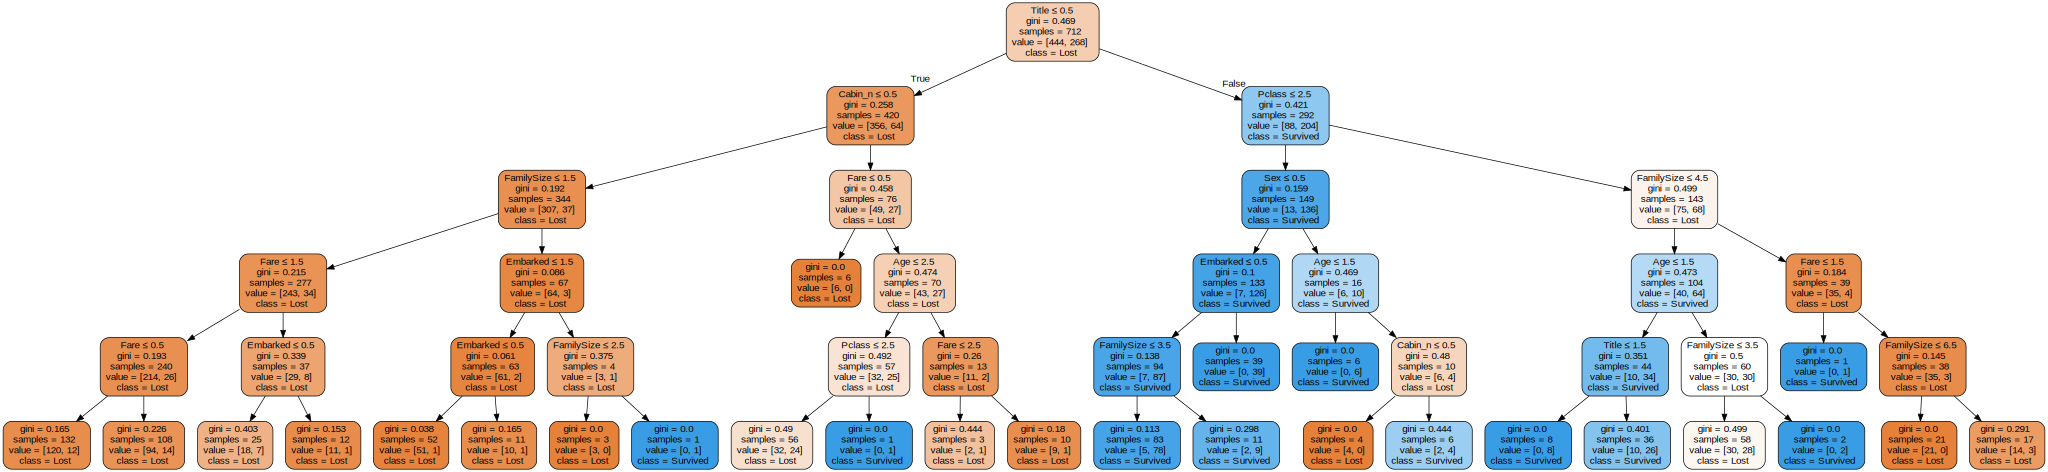

In [ ]:
dot_data = export_graphviz(tree_model, 
                           out_file=None,
                           filled=True,
                           rounded=True,
                           class_names = ['Lost', 'Survived'],  
                           special_characters=True,
                           feature_names = x.columns) 

graph = graphviz.Source(dot_data)
graph

In [ ]:
graph.render("passengerSurvi_new")

'passengerSurvi_new.pdf'

- 1st line of each node : (except those of the final row) shows the splitting condition in the form " feature <= value "
- next, Gini: (Gini ratio)==> measures the impurity of the node. 
- Samples: just the number of observations contained in the node.
- Value : [number of death, number of survivals]. 
- Last, class: is the predominant class of each node, 
and this is how our model will classify an observation. The colour also represents the class, the opacity increasing with the actual distribution of samples.

    * What do we see? the predominant class is Lost
    *- Most branches in the left side of the tree lead to an orange node 
    *- orange = Lost, blue = survived
    *- If our observation includes ==>
        * (title <=0.5) "Mr" or some other Men in title feature the braves one, 
        * without a cabine(cabin <=0.5)
        * without family (FamilySize ≤ 1.5)
        * with a cheap fare (Fare ≤ 1.5 or < 0.5)
        most of them did not survived (lost)
    *- if doesn't include "Mr" or others in Title ==> witch mean women(include children) and some other imporant person
        * (title <=0.5) False
        * Pclass first or second (Pclass ≤ 2.5) values are = [88(no), 204(yes)] 
        * most of them did survived

    *- If it doesn't include "Mr" Title & FamilySize <=4, --> survived.

    *- If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is 2 or less, -> survived.

    *- If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is more than 2, -> not survived
    
* most of men in third class are lost and most of women/children in the shipwreck survived


* **Change the decision tree parameters**

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=20, max_depth=10, min_samples_split=5)
decision_tree_model = decision_tree.fit(x_train, y_train)

* **Calculate the accuracy & compare it with the old one**

In [ ]:
# evaluating our model
y_pred_= decision_tree_model.predict(x_test)

# Measuring the accuracy of our model
accuracy = accuracy_score(y_test, y_pred) * 100
accuracy_ = accuracy_score(y_test, y_pred_) * 100
print("Accuracy with defaut decision tree: %.3f" %accuracy,"%")
print("Accuracy with decision tree with param: %.3f" %accuracy_,"%")

Accuracy with defaut decision tree: 82.682 %
Accuracy with decision tree with param: 83.799 %


- note : there is no big change, when i tried to change the max_depth to 10 the accuracy increase with just 0.11 (1.1%) 

# **Random forest**

In [ ]:
# Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Creating a random forest 
random = RandomForestClassifier()

In [ ]:
#Training our model
random_model = random.fit(x_train, y_train) 

In [ ]:

y_pred_random = random_model.predict(x_test)

accuracy_random = accuracy_score(y_test, y_pred_random) * 100
print("Accuracy: %.2f" %accuracy_random,"%")

Accuracy: 82.68 %


* **change the number of estimators**

In [ ]:
random_ = RandomForestClassifier(n_estimators= 200)
random_model_ = random_.fit(x_train, y_train) 
y_pred_random_ = random_model_.predict(x_test)
accuracy_random_ = accuracy_score(y_test, y_pred_random_) * 100
print("Accuracy: %.2f" %accuracy_random_,"%")

Accuracy: 83.24 %


* **compare All SCores:**

In [ ]:
# Measuring the accuracy of our model
# simple DT
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

# Dt with param
accuracy_Dt = accuracy_score(y_test, y_pred_) * 100
f1_Dt = f1_score(y_test, y_pred_) * 100
precision_Dt = precision_score(y_test, y_pred_) * 100
recall_Dt = recall_score(y_test, y_pred_) * 100

# random forest with estimator = 100
accuracy_rand = accuracy_score(y_test, y_pred_random) * 100
f1_rand = f1_score(y_test, y_pred_random) * 100
precision_rand = precision_score(y_test, y_pred_random) * 100
recall_rand = recall_score(y_test, y_pred_random) * 100

# random forest with estimator = 200
accuracy_rand2 = accuracy_score(y_test, y_pred_random_) * 100
f1_rand2 = f1_score(y_test, y_pred_random_) * 100
precision_rand2 = precision_score(y_test, y_pred_random_) * 100
recall_rand2 = recall_score(y_test, y_pred_random_) * 100

In [ ]:
print('The Scores of Decision Tree with Max depth = 5:\n')
print('*'*50)

print("Accuracy score = %.2f" %accuracy,"%")
print("f1 score = %.2f" %f1,"%")
print("precision score = %.2f" %precision,"%")
print("recall score = %.2f" %recall,"%")

print('\nThe Scores of Decision Tree with Max depth = 10:\n')
print('*'*50)

print("Accuracy score = %.2f" %accuracy_Dt,"%")
print("f1 score = %.2f" %f1_Dt,"%")
print("precision score = %.2f" %precision_Dt,"%")
print("recall score = %.2f" %recall_Dt,"%")

print('\nThe Scores of Random Forest (100 trees):\n')
print('*'*40)

print("Accuracy score = %.2f" %accuracy_rand,"%")
print("f1 score = %.2f" %f1_rand,"%")
print("precision score = %.2f" %precision_rand,"%")
print("recall score = %.2f" %recall_rand,"%")

print('\nThe Scores of Random Forest (200 trees):\n')
print('*'*40)

print("Accuracy score = %.2f" %accuracy_rand2,"%")
print("f1 score = %.2f" %f1_rand2,"%")
print("precision score = %.2f" %precision_rand2,"%")
print("recall score = %.2f" %recall_rand2,"%")

The Scores of Decision Tree with Max depth = 5:

**************************************************
Accuracy score = 82.68 %
f1 score = 75.20 %
precision score = 92.16 %
recall score = 63.51 %

The Scores of Decision Tree with Max depth = 10:

**************************************************
Accuracy score = 83.80 %
f1 score = 77.86 %
precision score = 89.47 %
recall score = 68.92 %

The Scores of Random Forest (100 trees):

****************************************
Accuracy score = 82.68 %
f1 score = 77.37 %
precision score = 84.13 %
recall score = 71.62 %

The Scores of Random Forest (200 trees):

****************************************
Accuracy score = 83.24 %
f1 score = 77.94 %
precision score = 85.48 %
recall score = 71.62 %


In [ ]:
# Accuracy score = 83.80 %
# f1 score = 77.86 %
# precision score = 89.47 %
# recall score = 68.92 %

* the best model is decision tree with max depth = 10 (acuuracy = 83.80% & f1-score = 77.86%)

* in accuracy : we have got 83.80 wich means our model is approx. 84% accurate.
    - the accuracy score is simply a ratio of correctly predicted observation to the total observations
* in precision : We have got 89.47% precision wich is pretty good
    - the question is: if all passengers that labeled as survived, how many actually survived? 
    - High precision relates to the low false positive rate    
* Recall: We have got recall of approx 69% wich is good for this model as it’s above 0.5(50%)
    - is the ratio of correctly predicted positive observations to the all observations in actual class - yes (survived)
    -  the question is : if all the passengers that truly survived ?
* **f1-Score**: we have got 77,86% : wich is not too bad,
    - this score takes both FP & FN into account.
    - F1-SCORE is usually more useful than accuracy, especially if we have an uneven class distribution. 
    - Accuracy works best if FP & FN have similar cost (symmetric datasets). 
    - but If the value of FP & FN are very different, it’s better to look at both Precision and Recall.